In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    #rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

In [4]:
data = pd.read_csv('Combined_all_3rd_fit.csv', encoding='cp1252')
print(data.columns.values)

['Name' 'Coef_a' 'Coef_b' 'Coef_c' 'Coef_d' 'A_site' 'B_site' 'X_site'
 'Spacegroup' 'Ehull' 'BulkModulus' 'Energy' 'ZPE' 's_A' 's_B' 's_X'
 'density' 'mean_A2B' 'mean_A2X' 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X'
 'std_B2X' 'std_X2X' 'E_coh' 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M'
 'A_G' 'B_G' 'X_G' 'A_IEI' 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII'
 'A_EA' 'B_EA' 'X_EA' 'A_ChiP' 'B_ChiP' 'X_ChiP' 'A_ChiA' 'X_ChiA'
 'A_Rvdw' 'B_Rvdw' 'X_Rvdw' 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra'
 'A_MP' 'B_MP' 'X_MP' 'A_BP' 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'A_MV' 'B_MV'
 'X_MV' 'A_Hf' 'B_Hf' 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa'
 'X_Kappa' 'A_CvM' 'B_CvM' 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo'
 'B_MendeleevNo' 'X_MendeleevNo']


In [5]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coef_b', 'Coef_c', 'Coef_a'], axis=1, inplace = True)
target = 'Coef_d'

In [6]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [7]:
data_std=d.copy()
scalerSTD=StandardScaler()
scalerSTD.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scalerSTD.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [8]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 51)


In [9]:
#data_std.to_csv("scaled_non_correlated.csv")

### Using CV technique

RF
R2:  0.9100802832729049
RMSE:  0.29986616469200905
---------------------------------------
GB
R2:  0.8002308877379021
RMSE:  0.4469553806165644
---------------------------------------
RR
R2:  0.4388698741311787
RMSE:  0.7490861938848034
---------------------------------------
LASSO
R2:  0.9245425628211686
RMSE:  0.2746951713788056
---------------------------------------
gpr1
R2:  0.867617269016495
RMSE:  0.363844377424614
---------------------------------------
gpr2
R2:  0.9265558061210752
RMSE:  0.2710058927014775
---------------------------------------
gpr3
R2:  0.9215789539830068
RMSE:  0.28003757965136256
---------------------------------------
gpr4
R2:  0.9430635991109445
RMSE:  0.23861349687110228
---------------------------------------
[0.9100802832729049, 0.8002308877379021, 0.4388698741311787, 0.9245425628211686, 0.867617269016495, 0.9265558061210752, 0.9215789539830068, 0.9430635991109445]


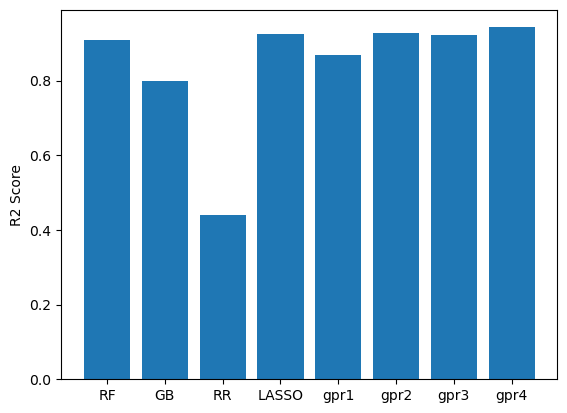

In [10]:
run_models()

## Feature selection


In [11]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
28      X_EA  95.250147
35      X_Ra  67.173814
1        s_B  61.964962
17       X_Z  57.414810
25    X_IEII  55.097923
4   mean_A2B  47.874859
2        s_X  43.799906
7   mean_X2X  33.902649
0        s_A  29.880346
33    A_Rvdw  27.535795
34      B_Ra  24.230307
20     A_IEI  23.950524
5   mean_A2X  22.081705
42      B_Hf  21.205026
16       B_Z  20.419989
14        OF  19.424616
10   std_B2X  16.266083
31    A_ChiA  15.842395
9    std_A2X  12.236469
26      A_EA  12.192466
29    A_ChiP  11.872273
12     E_coh  11.792747
36      B_MP  10.539184
47     B_CvM  10.158055
39     B_Rho   8.929870
37      A_BP   8.076791
41      X_MV   7.709740
40      B_MV   7.166166
8    std_A2B   7.106288
13        TF   7.008817


In [12]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_Z', 'X_IEII', 'mean_A2B', 's_X',
       'mean_X2X', 's_A', 'A_Rvdw', 'B_Ra', 'A_IEI', 'mean_A2X', 'B_Hf',
       'B_Z', 'OF', 'std_B2X', 'A_ChiA', 'std_A2X', 'A_EA', 'A_ChiP',
       'E_coh', 'B_MP', 'B_CvM', 'B_Rho', 'A_BP', 'X_MV', 'B_MV',
       'std_A2B', 'TF', 'A_Z', 'A_Kappa', 'std_X2X', 'A_CvM', 'A_B',
       'A_G', 'B_IEII', 'X_Kappa', 'B_B', 'B_Kappa'], dtype=object)

In [13]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9133853158605958
RMSE:  0.294303727702189
---------------------------------------
GB
R2:  0.7432177479925391
RMSE:  0.5067368666353977
---------------------------------------
RR
R2:  0.17393232917749002
RMSE:  0.9088826496432365
---------------------------------------
LASSO
R2:  0.9250861118668574
RMSE:  0.2737040155590388
---------------------------------------
gpr1
R2:  0.7528607279399759
RMSE:  0.4971310411350553
---------------------------------------
gpr2
R2:  0.9184912920022246
RMSE:  0.28549729945793795
---------------------------------------
gpr3
R2:  0.9072266139815597
RMSE:  0.3045872387649231
---------------------------------------
gpr4
R2:  0.9332433557473593
RMSE:  0.25837307184116676
---------------------------------------
[0.9133853158605958, 0.7432177479925391, 0.17393232917749002, 0.9250861118668574, 0.7528607279399759, 0.9184912920022246, 0.9072266139815597, 0.9332433557473593]


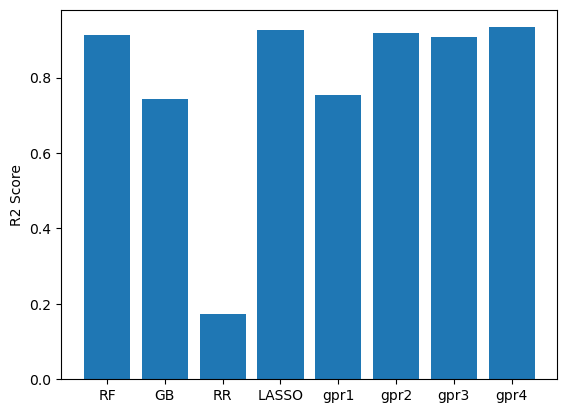

In [14]:
run_models()

In [15]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_Z', 'X_IEII', 'mean_A2B', 's_X',
       'mean_X2X', 's_A', 'A_Rvdw', 'B_Ra', 'A_IEI', 'mean_A2X', 'B_Hf',
       'B_Z', 'OF', 'std_B2X', 'A_ChiA', 'std_A2X', 'A_EA', 'A_ChiP',
       'E_coh', 'B_MP', 'B_CvM', 'B_Rho', 'A_BP', 'X_MV', 'B_MV',
       'std_A2B', 'TF'], dtype=object)

In [16]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
t30_columns = ['mean_A2B', 's_X', 'X_Ra', 'X_EA', 'X_Z', 'mean_X2X', 'A_Rvdw',
       's_A', 'mean_A2X', 's_B', 'A_IEI', 'E_coh', 'A_ChiA', 'std_A2X',
       'X_IEII', 'B_Hf', 'A_ChiP', 'B_MP', 'A_BP', 'std_B2X', 'A_Z',
       'X_Kappa', 'A_EA', 'B_Ra', 'OF', 'A_CvM', 'B_Z', 'A_Kappa',
       'B_Kappa', 'X_ChiA']
data_save=data_std[t30_columns]
#data_save.to_csv("scaled_top_30.csv")

RF
R2:  0.8906015260080116
RMSE:  0.3307544013191487
---------------------------------------
GB
R2:  0.7710501067535407
RMSE:  0.47848708785761335
---------------------------------------
RR
R2:  0.6946866085554434
RMSE:  0.552551709294756
---------------------------------------
LASSO
R2:  0.914693129181694
RMSE:  0.2920733997102543
---------------------------------------
gpr1
R2:  0.7699747512027411
RMSE:  0.4796094752997056
---------------------------------------
gpr2
R2:  0.9138258172686928
RMSE:  0.2935543948424332
---------------------------------------
gpr3
R2:  0.9005407945852348
RMSE:  0.3153715355176575
---------------------------------------
gpr4
R2:  0.9030430850206848
RMSE:  0.3113790535333346
---------------------------------------
[0.8906015260080116, 0.7710501067535407, 0.6946866085554434, 0.914693129181694, 0.7699747512027411, 0.9138258172686928, 0.9005407945852348, 0.9030430850206848]


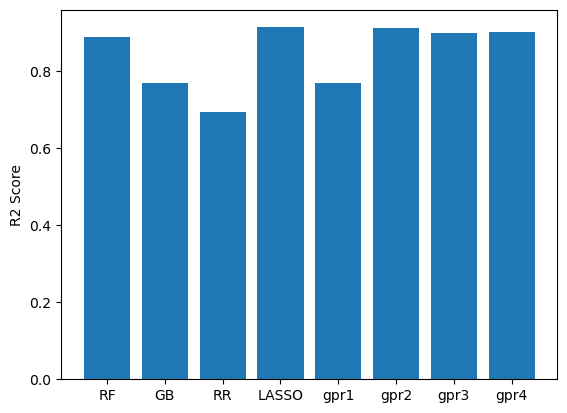

In [17]:
run_models()

In [18]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_Z', 'X_IEII', 'mean_A2B', 's_X',
       'mean_X2X', 's_A', 'A_Rvdw', 'B_Ra', 'A_IEI', 'mean_A2X', 'B_Hf',
       'B_Z', 'OF', 'std_B2X', 'A_ChiA', 'std_A2X', 'A_EA'], dtype=object)

In [19]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9195467277775806
RMSE:  0.2836428603409918
---------------------------------------
GB
R2:  0.7714831258011493
RMSE:  0.4780343860004746
---------------------------------------
RR
R2:  0.9163638912559187
RMSE:  0.2891990815062892
---------------------------------------
LASSO
R2:  0.9265832004620743
RMSE:  0.27095534602204413
---------------------------------------
gpr1
R2:  0.9262062237757485
RMSE:  0.27165009888503916
---------------------------------------
gpr2
R2:  0.9419369560695678
RMSE:  0.2409627438639263
---------------------------------------
gpr3
R2:  0.9055501436617891
RMSE:  0.30732695348473893
---------------------------------------
gpr4
R2:  0.9378595014977491
RMSE:  0.2492799600895565
---------------------------------------
[0.9195467277775806, 0.7714831258011493, 0.9163638912559187, 0.9265832004620743, 0.9262062237757485, 0.9419369560695678, 0.9055501436617891, 0.9378595014977491]


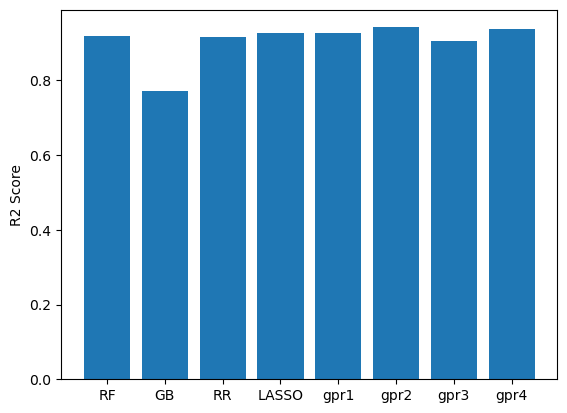

In [20]:
run_models()

In [21]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_Z', 'X_IEII', 'mean_A2B', 's_X',
       'mean_X2X', 's_A', 'A_Rvdw'], dtype=object)

In [22]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8916041065034778
RMSE:  0.3292353162959926
---------------------------------------
GB
R2:  0.7102564361622676
RMSE:  0.5382783330561731
---------------------------------------
RR
R2:  0.8711370741974442
RMSE:  0.3589748261404354
---------------------------------------
LASSO
R2:  0.8861295773556725
RMSE:  0.33744691826171347
---------------------------------------
gpr1
R2:  0.8797974522262987
RMSE:  0.3467023907816346
---------------------------------------
gpr2
R2:  0.9280941015598614
RMSE:  0.26815275206519623
---------------------------------------
gpr3
R2:  0.9069509137598137
RMSE:  0.305039483084053
---------------------------------------
gpr4
R2:  0.9003366599523185
RMSE:  0.31569501112257303
---------------------------------------
[0.8916041065034778, 0.7102564361622676, 0.8711370741974442, 0.8861295773556725, 0.8797974522262987, 0.9280941015598614, 0.9069509137598137, 0.9003366599523185]


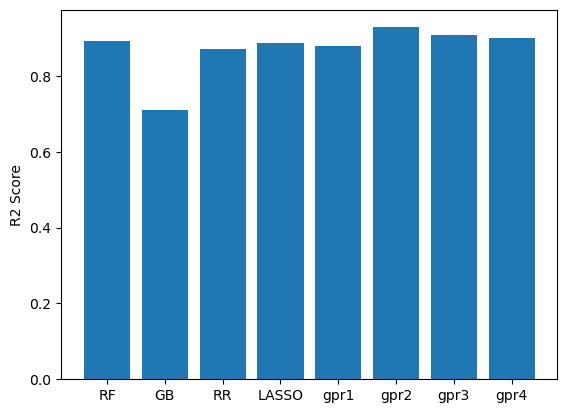

In [23]:
run_models()

# Min-Max scaling

In [24]:
data_std=d.copy()
scalerMM=MinMaxScaler()
scalerMM.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scalerMM.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [25]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)
#data_std.to_csv('Coef_a_scaled_non_corr_all.csv',index=False)

(80, 51)


### Using CV technique

RF
R2:  0.9139772518834098
RMSE:  0.0678960341598605
---------------------------------------
GB
R2:  0.8083999128768663
RMSE:  0.10132943066102647
---------------------------------------
RR
R2:  0.8685039093281136
RMSE:  0.08394487218476027
---------------------------------------
LASSO
R2:  0.5550187696567432
RMSE:  0.15442179543841533
---------------------------------------
gpr1
R2:  0.9303403663151799
RMSE:  0.06109818997806604
---------------------------------------
gpr2
R2:  -0.04816258460452438
RMSE:  0.23700203653493743
---------------------------------------
gpr3
R2:  0.9433394162624843
RMSE:  0.05510338439578436
---------------------------------------
gpr4
R2:  0.9201968403075249
RMSE:  0.06539548949154776
---------------------------------------
[0.9139772518834098, 0.8083999128768663, 0.8685039093281136, 0.5550187696567432, 0.9303403663151799, -0.04816258460452438, 0.9433394162624843, 0.9201968403075249]


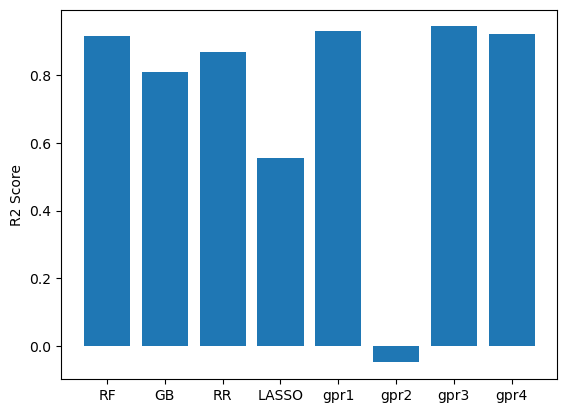

In [26]:
run_models()

## Feature selection


In [27]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
28      X_EA  95.250147
35      X_Ra  67.173814
1        s_B  61.964962
17       X_Z  57.414810
25    X_IEII  55.097923
4   mean_A2B  47.874859
2        s_X  43.799906
7   mean_X2X  33.902649
0        s_A  29.880346
33    A_Rvdw  27.535795
34      B_Ra  24.230307
20     A_IEI  23.950524
5   mean_A2X  22.081705
42      B_Hf  21.205026
16       B_Z  20.419989
14        OF  19.424616
10   std_B2X  16.266083
31    A_ChiA  15.842395
9    std_A2X  12.236469
26      A_EA  12.192466
29    A_ChiP  11.872273
12     E_coh  11.792747
36      B_MP  10.539184
47     B_CvM  10.158055
39     B_Rho   8.929870
37      A_BP   8.076791
41      X_MV   7.709740
40      B_MV   7.166166
8    std_A2B   7.106288
13        TF   7.008817


In [28]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_Z', 'X_IEII', 'mean_A2B', 's_X',
       'mean_X2X', 's_A', 'A_Rvdw', 'B_Ra', 'A_IEI', 'mean_A2X', 'B_Hf',
       'B_Z', 'OF', 'std_B2X', 'A_ChiA', 'std_A2X', 'A_EA', 'A_ChiP',
       'E_coh', 'B_MP', 'B_CvM', 'B_Rho', 'A_BP', 'X_MV', 'B_MV',
       'std_A2B', 'TF', 'A_Z', 'A_Kappa', 'std_X2X', 'A_CvM', 'A_B',
       'A_G', 'B_IEII', 'X_Kappa', 'B_B', 'B_Kappa'], dtype=object)

In [29]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9071154105616547
RMSE:  0.07055204137418054
---------------------------------------
GB
R2:  0.7896330111111197
RMSE:  0.10617604564600285
---------------------------------------
RR
R2:  0.6988801320622924
RMSE:  0.12703033898454094
---------------------------------------
LASSO
R2:  0.5550112222262307
RMSE:  0.1544231050249206
---------------------------------------
gpr1
R2:  0.8565678458359851
RMSE:  0.0876720197748117
---------------------------------------
gpr2
R2:  -0.04816259706028214
RMSE:  0.23700203794313499
---------------------------------------
gpr3
R2:  0.9337954364815764
RMSE:  0.05956370646189312
---------------------------------------
gpr4
R2:  0.9122146873743948
RMSE:  0.06858808563771485
---------------------------------------
[0.9071154105616547, 0.7896330111111197, 0.6988801320622924, 0.5550112222262307, 0.8565678458359851, -0.04816259706028214, 0.9337954364815764, 0.9122146873743948]


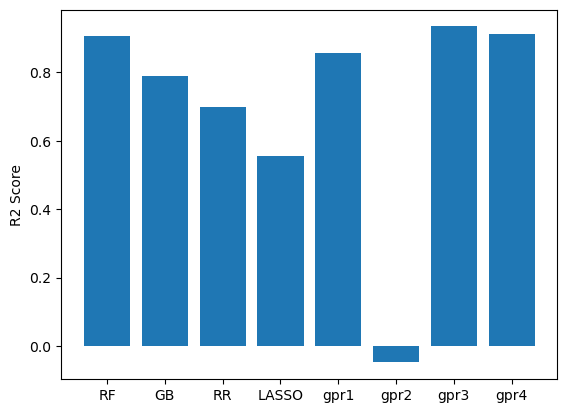

In [30]:
run_models()

In [31]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_Z', 'X_IEII', 'mean_A2B', 's_X',
       'mean_X2X', 's_A', 'A_Rvdw', 'B_Ra', 'A_IEI', 'mean_A2X', 'B_Hf',
       'B_Z', 'OF', 'std_B2X', 'A_ChiA', 'std_A2X', 'A_EA', 'A_ChiP',
       'E_coh', 'B_MP', 'B_CvM', 'B_Rho', 'A_BP', 'X_MV', 'B_MV',
       'std_A2B', 'TF'], dtype=object)

In [32]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9047070265509742
RMSE:  0.07146085213723664
---------------------------------------
GB
R2:  0.8027015811437251
RMSE:  0.10282519784436578
---------------------------------------
RR
R2:  0.7831817393433687
RMSE:  0.10779178889056634
---------------------------------------
LASSO
R2:  0.5550112222262307
RMSE:  0.1544231050249206
---------------------------------------
gpr1
R2:  0.8573347096147909
RMSE:  0.08743733528970424
---------------------------------------
gpr2
R2:  -0.04816258169394927
RMSE:  0.2370020362058796
---------------------------------------
gpr3
R2:  0.9187832167163678
RMSE:  0.06597215089921069
---------------------------------------
gpr4
R2:  0.913934371506329
RMSE:  0.06791295436343252
---------------------------------------
[0.9047070265509742, 0.8027015811437251, 0.7831817393433687, 0.5550112222262307, 0.8573347096147909, -0.04816258169394927, 0.9187832167163678, 0.913934371506329]


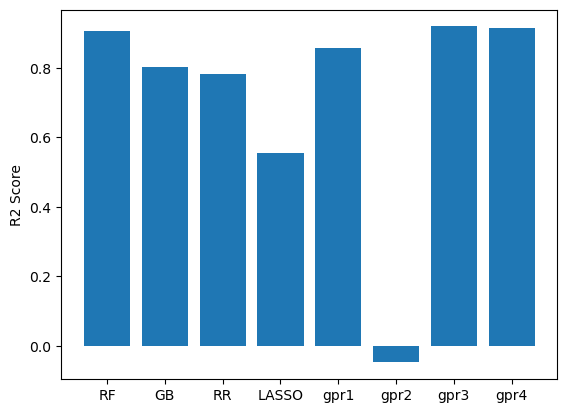

In [33]:
run_models()

In [34]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_Z', 'X_IEII', 'mean_A2B', 's_X',
       'mean_X2X', 's_A', 'A_Rvdw', 'B_Ra', 'A_IEI', 'mean_A2X', 'B_Hf',
       'B_Z', 'OF', 'std_B2X', 'A_ChiA', 'std_A2X', 'A_EA'], dtype=object)

In [35]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8917385896366032
RMSE:  0.07616835769301931
---------------------------------------
GB
R2:  0.7531453433421748
RMSE:  0.11501604071127909
---------------------------------------
RR
R2:  0.921937897973758
RMSE:  0.06467819214255174
---------------------------------------
LASSO
R2:  0.5550112222262307
RMSE:  0.1544231050249206
---------------------------------------
gpr1
R2:  0.8903795832267316
RMSE:  0.07664493775172034
---------------------------------------
gpr2
R2:  -0.048162553651292406
RMSE:  0.23700203303549033
---------------------------------------
gpr3
R2:  0.9350589879990845
RMSE:  0.058992564689315706
---------------------------------------
gpr4
R2:  0.9314604772677703
RMSE:  0.060604976804842545
---------------------------------------
[0.8917385896366032, 0.7531453433421748, 0.921937897973758, 0.5550112222262307, 0.8903795832267316, -0.048162553651292406, 0.9350589879990845, 0.9314604772677703]


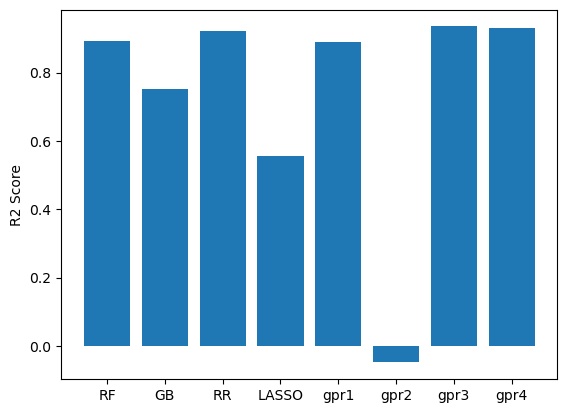

In [36]:
run_models()

In [37]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Ra', 's_B', 'X_Z', 'X_IEII', 'mean_A2B', 's_X',
       'mean_X2X', 's_A', 'A_Rvdw'], dtype=object)

In [38]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.899107703223174
RMSE:  0.07353037074723756
---------------------------------------
GB
R2:  0.6941795864577078
RMSE:  0.12801798496234984
---------------------------------------
RR
R2:  0.8735805190059737
RMSE:  0.08230851246480635
---------------------------------------
LASSO
R2:  0.48716333505619513
RMSE:  0.16577814854113979
---------------------------------------
gpr1
R2:  0.882641989692129
RMSE:  0.07930382235111352
---------------------------------------
gpr2
R2:  -0.048162640693473424
RMSE:  0.23700204287612683
---------------------------------------
gpr3
R2:  0.9147787016996936
RMSE:  0.06757900987203551
---------------------------------------
gpr4
R2:  0.9198127343518796
RMSE:  0.06555268028675802
---------------------------------------
[0.899107703223174, 0.6941795864577078, 0.8735805190059737, 0.48716333505619513, 0.882641989692129, -0.048162640693473424, 0.9147787016996936, 0.9198127343518796]


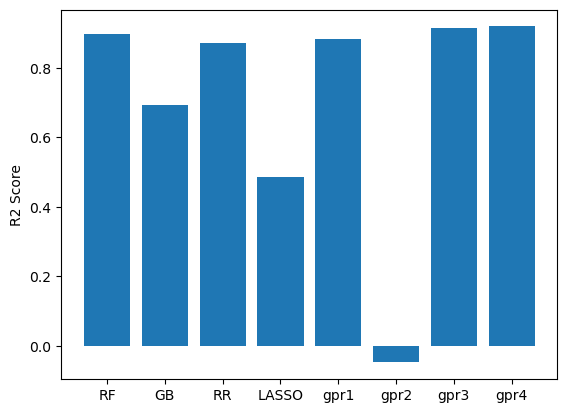

In [39]:
run_models()